In [ ]:
%load_ext autoreload
%autoreload 2

In [66]:
#export
from nb_002 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'

train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test', train_ds.classes)

x = train_ds[1][0]
bs=256

# CIFAR augmentation

In [68]:
#export
@reg_transform
def pad(x, padding, mode='reflect') -> TfmType.Start:
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@reg_transform
def crop(x, size, row_pct:uniform, col_pct:uniform) -> TfmType.Pixel:
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows)*row_pct)
    col = int((x.size(2)-cols)*col_pct)
    return x[:, row:row+rows, col:col+cols]

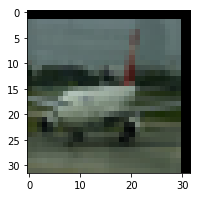

In [69]:
show_image(crop(pad(x, 4, 'constant'), 32, 0.25, 0.75), hide_axis=False)

In [70]:
tfms = [flip_lr_tfm(p=0.5),
        pad_tfm(padding=4, mode='constant'),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [71]:
#export
@dataclass
class TfmDataset(Dataset):
    ds: Dataset
    tfms: Collection[Callable] = None
        
    def __len__(self): return len(self.ds)
    
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None: x = apply_tfms(self.tfms)(x)
        return x,y
    
class DataBunch():
    def __init__(self, train_ds, valid_ds, bs=64, device=None, train_tfm=None, valid_tfm=None, num_workers=4):
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader.create(TfmDataset(train_ds,train_tfm), bs, shuffle=True, num_workers=num_workers)
        self.valid_dl = DeviceDataLoader.create(TfmDataset(valid_ds, valid_tfm), bs*2, shuffle=False, num_workers=num_workers)
        
    @property
    def train_ds(self): return self.train_dl.dl.dataset
    @property
    def valid_ds(self): return self.valid_dl.dl.dataset

In [93]:
data = DataBunch(train_ds, valid_ds, train_tfm=tfms)

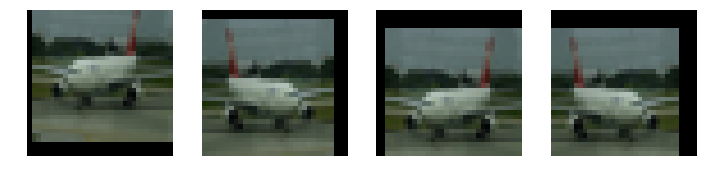

In [94]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: show_image(data.train_ds[1][0], ax)

## Normalization and training

In [95]:
# CIFAR 10 stats looked up on google 
data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))

In [96]:
#export
@reg_transform
def normalize(x, mean,std) -> TfmType.Pixel:
    return (x-mean[...,None,None]) / std[...,None,None]

def denormalize(x, mean,std):
    return x*std[...,None,None] + mean[...,None,None]

In [97]:
cifar_norm = normalize_tfm(mean=data_mean,std=data_std)

In [98]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=8)
len(data2.train_dl), len(data2.valid_dl)

(40, 4)

In [99]:
x,y = next(iter(data2.train_dl))
x = x.cpu()

In [100]:
x = denormalize(x, data_mean, data_std).clamp(0,1.)

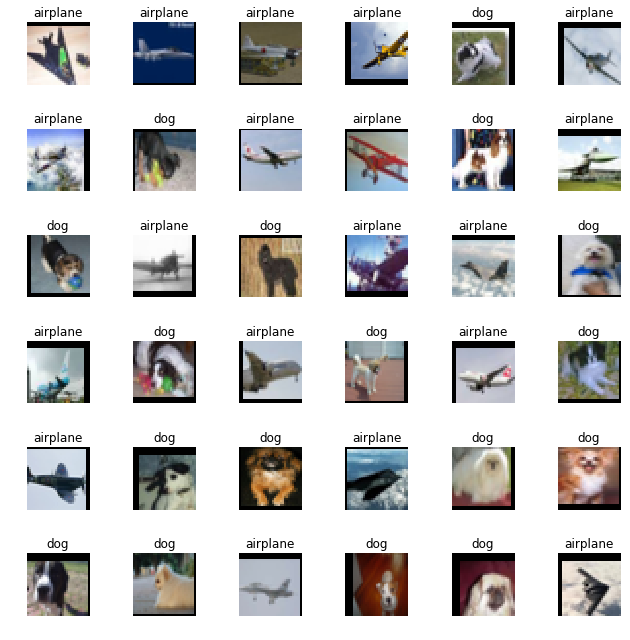

In [101]:
show_images(x,y,6,train_ds.classes)

In [102]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [103]:
opt_fn = partial(optim.SGD, momentum=0.9)

In [105]:
learn.fit(2, 0.1, opt_fn=opt_fn)

0 0.35246057415008547


1 0.29522917890548706


# Fin